In [1]:
%matplotlib inline
# math libs
import math
import numpy as np
from scipy.spatial import distance
from scipy.spatial import ConvexHull

# plotting libs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random

In [2]:
def parse_points(points):
    X = [elem[0] for elem in points]
    Y = [elem[1] for elem in points]
    Z = [elem[2] for elem in points]
    return X, Y, Z

def gen_random_point(dim, lower=-1e1, upper=1e1):
    return [random.uniform(lower, upper) for i in range(dim)]

def plot_points(points,
                size=(15,12),
                style='g.', legend='No label'):
    pp = parse_points(points)
    figure = plt.figure(figsize=size)
    ax = figure.gca(projection='3d')
    ax.plot(pp[0], pp[1], pp[2], style,label=legend, alpha=0.6)
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')
    ax.legend()
    
    return ax

In [3]:
class Algorithm:
    x = []
    
    
    def __init__(self, points, weights):
        self.points = points
        self.weights = weights
        
        
    def solve(self, x_0, epsilon): ...
        

    def _w(self, i, y):
        ans = self.weights[i] / distance.euclidean(y, self.points[i])
        coef = 0.
        for j in range(len(self.points)):
            if not np.array_equal(y, self.points[j]):
                coef = coef + self.weights[j] / distance.euclidean(y, self.points[j])
        return ans / coef
    
    
    def _tilde_T(self, y):
        ans = 0.
        for i in range(len(self.points)):
            if not np.array_equal(y, self.points[i]):
                ans = ans + self._w(i, y) * self.points[i]

        return ans

## A Modified Weiszfeld algorhitm

Let $$d_i(y) \equiv \lVert y - x_i \rVert$$

Than $$w_i(y) = \frac{\eta_i}{d_i(y)} \Big\{  \sum\limits_{x_j \neq y}^{} \frac{n_j}{d_j(y)} \Big\} ^{-1} $$

$$\tilde{T}: y \to \tilde{T}(y) \equiv \sum\limits_{x_i \neq y}^{} w_i(y)x_i$$

Than

$$y \to T_0(y) = \begin{cases} \tilde{T}(y), & \mbox{if } y \notin \{x_1, ... , x_m \}\\ x_k, & \mbox{if } y = x_k, k = \overline{1,m} \end{cases}$$

In [4]:
class ModifiedWeiszfeld(Algorithm):
    
    def _T_0(self, y):
        for x in self.points:
            if np.array_equal(y, x):
                return x

        return self._tilde_T(y)
    
    
    def solve(self, x_0, epsilon):
        self.x = [x_0, self._T_0(x_0)]

        while not distance.euclidean(self.x[-1], self.x[-2]) < epsilon:
            self.x.append(self._T_0(self.x[-1]))

Let $x_1, ... , x_m$ be m distinct points in $R^{d}$ and $\eta_1, ... , \eta_m$ be $m$ positive numbers.

In [5]:
x = np.array([        
        np.array([1,-1,1]),
        np.array([1,-1,-1]),
        np.array([1,1,1]),
        np.array([1,1,-1]),
        np.array([-1,1,1]),
        np.array([-1,1,-1]),
        np.array([-1,-1,1]),
        np.array([-1,-1,-1]),
        np.array([1.5,0,0]),
        np.array([-1.5,0,0]),
        np.array([0,1.5,0]),
        np.array([0,-1.5,0]),
        np.array([0,0,1.5]),
        np.array([0,0,-1.5])
    ])

eta = np.array([random.randint(1, 1e1) for i in range(len(x))])

print(eta)

[6 5 1 2 9 9 6 7 3 2 3 5 3 8]


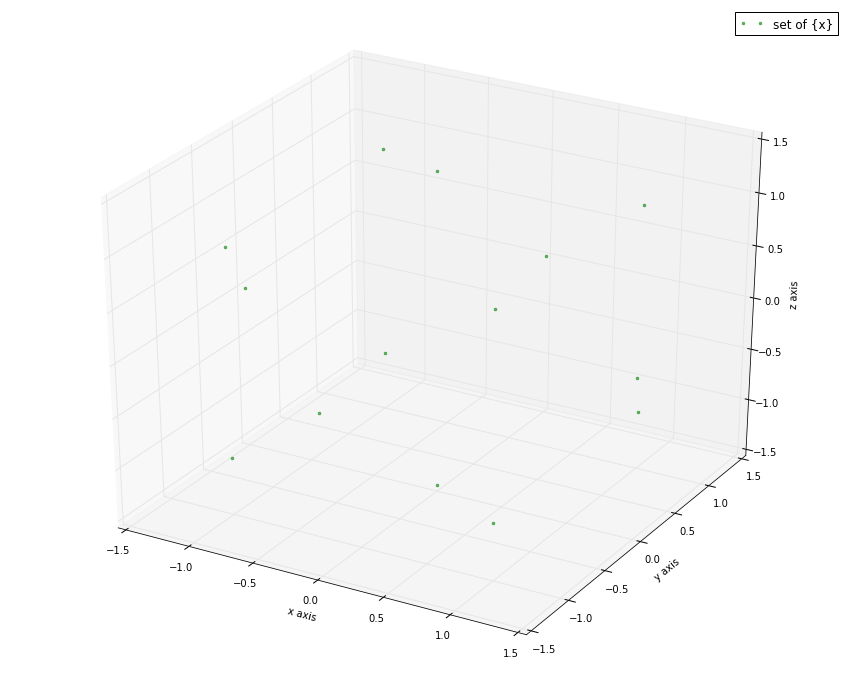

In [6]:
plot_points(x, legend="set of {x}")

Let initialise $y_0$ with some values.

In [7]:
y_0 = np.array([1.5,1.5,1.5])

Let $\varepsilon = 1E^{-10}$.

In [8]:
epsilon = 1e-10

In [9]:
mwzfld = ModifiedWeiszfeld(x, eta)
mwzfld.solve(y_0, epsilon)
mwzfld.x[-1]

array([-0.27489472, -0.10557004, -0.21151284])

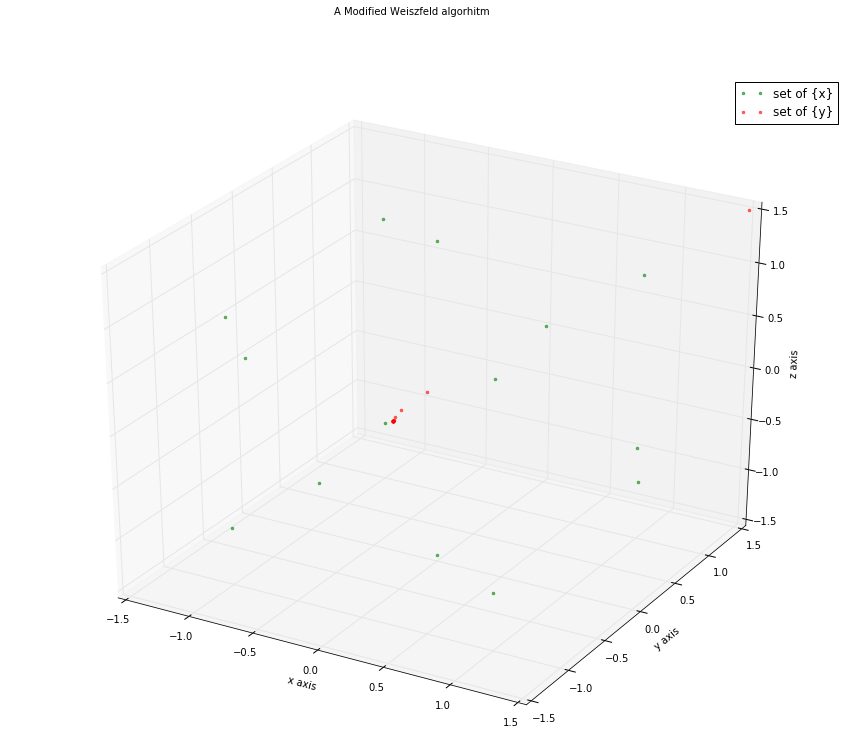

In [10]:
figure = plt.figure(figsize=(15,12))
ax = figure.gca(projection='3d')

pp = parse_points(x)
ax.plot(pp[0], pp[1], pp[2], 'g.', alpha=0.6)

pp = parse_points(mwzfld.x)
ax.plot(pp[0], pp[1], pp[2], 'r.', alpha=0.6)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
figure.suptitle('A Modified Weiszfeld algorhitm')
ax.legend(['set of {x}', 'set of {y}'])

## The new algorithm

$$y \to T(y) \equiv \Big( 1 - \frac{\eta(y)}{r(y)}\Big)^{+} \tilde{T}(y) + min \Big(1, \frac{\eta(y)}{r(y)}\Big)y$$

with convention 0/0 = 0 in the computation of $\eta(y) / r(y)$, where $\tilde{T}(y)$ is

$$\tilde{T}: y \to \tilde{T}(y) \equiv \sum\limits_{x_i \neq y}^{} w_i(y)x_i,$$

$$r(y) \equiv \lVert \tilde{R}(y) \rVert,$$

$$\tilde{R}(y) = \sum\limits_{x_i \neq y}^{} \eta_i \frac{x_i - y}{\lVert x_i - y \rVert}$$

$$\eta(y) \equiv \begin{cases} \eta_k, & \mbox{if } y = x_k, k = \overline{1,m} \\ 0, & \mbox{if } y \notin \{ x_1, ... , x_m\} \end{cases}$$

In [11]:
class NewAlgorithm(Algorithm):
    
    def _tilde_R(self, y):
        ans = np.zeros(len(y))
        for i in range(len(self.points)):
            if not np.array_equal(self.points[i], y):
                ans = ans + (self.points[i] - y) * self.weights[i] / distance.euclidean(self.points[i], y)
        return ans
    
    
    def _r(self, y):
        return distance.euclidean(0, self._tilde_R(y));
    
    
    def _Eta(self, y):
        for k in range(len(self.points)):
            if np.array_equal(y, self.points[k]):
                return self.weights[k]

        return 0
    
    
    def _new_tilde_T(self, y):
        tmp = self._Eta(y) / self._r(y)
        ans = max(0, 1 - tmp) * self._tilde_T(y) + min(1, tmp) * y
        return ans
    
    
    def solve(self, x_0, epsilon):
        self.x = [x_0, self._new_tilde_T(x_0)]

        while not distance.euclidean(self.x[-1], self.x[-2]) < epsilon:
            self.x.append(self._new_tilde_T(self.x[-1]))

In [12]:
nalgo = NewAlgorithm(x, eta)
nalgo.solve(y_0, epsilon)
nalgo.x[-1]

array([-0.27489472, -0.10557004, -0.21151284])

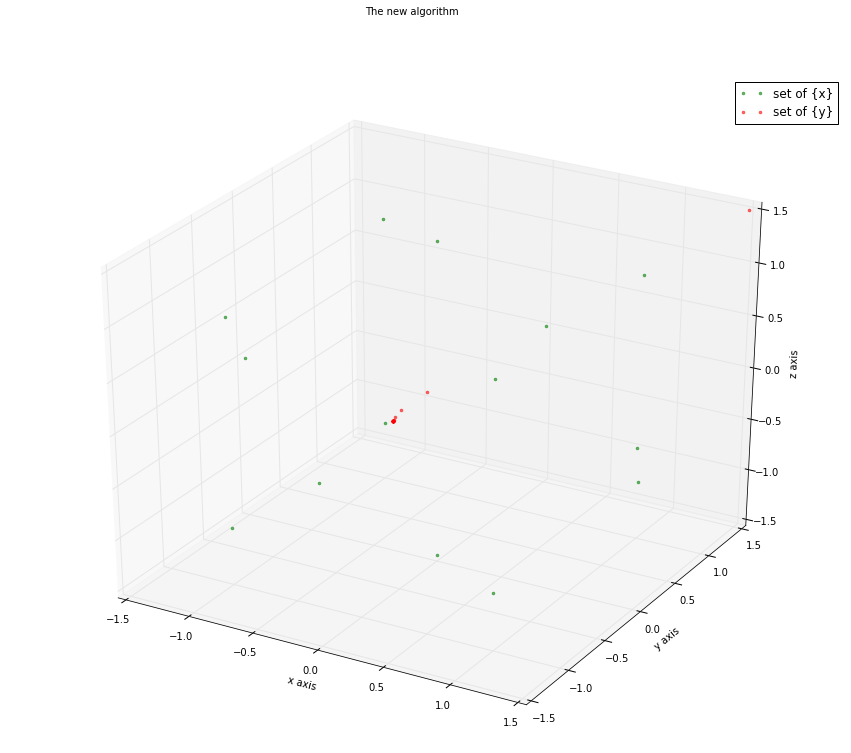

In [13]:
figure = plt.figure(figsize=(15,12))
ax = figure.gca(projection='3d')

pp = parse_points(x)
ax.plot(pp[0], pp[1], pp[2], 'g.', alpha=0.6)

pp = parse_points(nalgo.x)
ax.plot(pp[0], pp[1], pp[2], 'r.', alpha=0.6)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
figure.suptitle('The new algorithm')
ax.legend(['set of {x}', 'set of {y}'])

In [14]:
print('A Modified Weiszfeld algorhitm calculate:', mwzfld.x[-1])
print('The new algorithm calculate:', nalgo.x[-1])

A Modified Weiszfeld algorhitm calculate: [-0.27489472 -0.10557004 -0.21151284]
The new algorithm calculate: [-0.27489472 -0.10557004 -0.21151284]


### Some tests

In [15]:
def test(m, dimension):
    points = np.random.rand(m, dimension) # points from [0;1)
    hull = ConvexHull(points)
    points = [np.array(points[index]) for index in hull.vertices]
    weights = np.array([random.randint(1, 1000) for i in range(m)])

    started_point = np.array([random.uniform(-100., 100.) for i in range(dimension)])

    mwzfld = ModifiedWeiszfeld(points, weights)
    mwzfld.solve(started_point, 1e-5)

    nalgo = NewAlgorithm(points, weights)
    nalgo.solve(started_point, 1e-5)

    print('Dimension - ', dimension, ', count of points -', m)
    print('Weights:')
    print(weights)
    print('Modified -', mwzfld.x[-1], 'count of steps -', len(mwzfld.x))
    print('New algo -', nalgo.x[-1], 'count of steps -', len(nalgo.x))

In [18]:
test(random.randint(100, 200), 2)
print('\n')

test(random.randint(100, 300), 3)
print('\n')

test(random.randint(100, 400), 4)
print('\n')

test(random.randint(100, 500), 5)

Dimension -  2 , count of points - 164
Weights:
[ 206  943  535  801  951  275   64   62  644 1000   84  885  930  959  856
  942  722  300  175  607  573  237  582    2  651  925  108  680  988  940
  620  956  521  782  955  486  884   83  838  180  256   51  108  109  356
  832  880  283  775  561  533  150  145  430  175  807  889  738  138  818
  952  110  443  483  435  625  967  429  322  364  249  176  659  124  506
  985  870  526  719  895  214  808  141  663  963  495  116  358   31  728
  328  552  457  559  657   19  649  559  593  923  720  722  767  320  836
  355  521  467  729    4  463  209  543  206  322  136  472  443   70  933
  168  891   17  547  521  571  382  191  485  930  930  253  373  775  811
  235  792  129   56  736  284  523  339  318  114  806  960  953  184  858
  577  285  107  259  796  355  791  737  729  962   80  144   56  343]
Modified - [ 0.34869546  0.52925172] count of steps - 19
New algo - [ 0.34869546  0.52925172] count of steps - 19


Dime